In [1]:
import os
from DNASkittleUtils.DDVUtils import pp
import csv
from collections import defaultdict

# Lizzy's Data

In [2]:
from pandas import read_csv
liz = read_csv("GOenrich_db/lizzy_ash_ks.csv", sep='\t')
liz = liz[liz['Ks'] < 20]  # remove a couple bad values
print(len(liz), "pairs")

20865 pairs


In [3]:
wgd_recent = (liz['Ks'] > 0.16) & (liz['Ks'] < 0.38)
wgd_old = (liz['Ks'] > 0.5) & (liz['Ks'] < 0.8)
recent_duplication = liz['Ks'] < 0.2
unaffected =  ~wgd_old & ~recent_duplication  # ~wgd_recent &
affected = wgd_recent | wgd_old #| recent_duplication
len(liz[unaffected]), len(affected)
pp(len(liz[wgd_recent]) / len(liz))

'35.772825%'

In [4]:
liz.head()

,Group,Gene 1,Gene 2,Ks
0,10,130.1,342640.1,0.3768
1,10,130.1,254110.1,1.5491
2,10,130.1,83020.1,1.6002
3,10,342640.1,254110.1,2.8645
4,10,342640.1,83020.1,0.9481


In [5]:
from itertools import chain
def liz_rows_into_gene_list(liz):
    wgd_genes = set(['FRAEX38873_v2_' + str(x).zfill(11) for x in chain(liz['Gene 1'], liz['Gene 2'])])
    return wgd_genes
wgd_genes = liz_rows_into_gene_list(liz[wgd_recent])
pp(len(wgd_genes))

'13,033'

NameError: name 'liz' is not defined

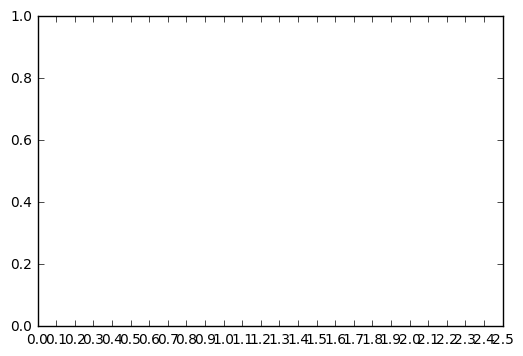

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xticks(np.arange(0, 2.6, .1))
h = liz[liz['Ks'] < 2.5]['Ks'].hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel('Ks')
h.set_ylabel('# of Genes')
h.set_title('Ks values of F. excelsior paralogs')

In [7]:
ortho_file = r"Ash_Proteome\Results_Jun25\Orthogroups.csv"
orthogroups = {}
excelsior_orthogroups = {}
OG_order = []
with open(ortho_file, newline='' ) as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for nLines, row in enumerate(reader):
        og = row[0].replace(':','')
        orthogroups[og] = {'genes': list(row[1:])}
        if any([name.startswith('FRAEX') for name in orthogroups[og]['genes']]):
            excelsior_orthogroups[og] = orthogroups[og]
        OG_order.append(og)
        
gene2family = {gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [8]:
# wgd_genes = liz_rows_into_gene_list(liz[(liz['Ks'] > .2) & (liz['Ks'] < .3)])
wgd_by_family = set()
for gene in wgd_genes:
    if gene in gene2family:
        wgd_by_family.add(gene2family[gene])
len(wgd_by_family), pp(len(wgd_by_family) / len(excelsior_orthogroups))

(6105, '27.210733%')

**Conculsion** Functional orthogroups is prefiltered to only have families where members of excelsior are present. This 30% result then means that 30% of the gene families where we could have detected a WGD showed evidence of a WGD. That's very consistent with other numbers I've gotten.  
The 3% discrepancy (30-27) between FunctionsForFamilies is because of the annotation != "NULL" requirement, which is not included here. 

# CAFE tree approximations

In [ ]:
from newick import loads
import newick

In [10]:
all_trees = {}
with open(r"CAFE-4.2\data\all_species\reports\WGD_manual_all_species.cafe", 'r') as csvfile:
    lines = csvfile.readlines()[11:]
    for nLines, row in enumerate(lines):
        row = row.split('\t')
        all_trees[int(row[0])] = row[1]
len(all_trees)

16191

In [11]:
ordered_names = loads('((((((((((((FRAX30:2,FRAX32:2)<1>:1,FRAX28:3)<3>:2,FRAX12:5)<5>:4,(FRAX07:8,FRAX29:8)<9>:1)<7>:4,FRAX08:13)<11>:1,(((((FRAX01:2,FRAX16:2)<15>:4,FRAX15:6)<17>:2,FRAX00:8)<19>:2,(FRAX06:9,FRAX23:9)<23>:1)<21>:3,FRAX25:13)<25>:1)<13>:3,FRAX21:17)<27>:2,(((FRAX19:8,FRAX20:8)<31>:2,((FRAX11:5,FRAX27:5)<35>:4,FRAX04:9)<37>:1)<33>:1,(((((FRAX03:1,FRAX09:1)<41>:1,FRAX13:2)<43>:2,(FRAX26:2,FRAX14:2)<47>:2)<45>:3,FRAX05:7)<49>:2,FRAX33:9)<51>:2)<39>:8)<29>:15,FRAX31:34)<53>:2,Oeuropea:36)<55>:1,empty:37)<57>:42,(Slycopersicum:37,Mguttatus:37)<61>:42)<59>')[0]
def create_ordered_nodes(verbose=False):
    ordered_nodes = []
    for node in ordered_names.walk(mode="preorder"):
        if verbose:
            print(node.name, node.length)
        ordered_nodes.append({'name': node.name, 'length':node.length, 'losses': 0, 'gains': 0, 'avg#': 0})
    return ordered_nodes
ordered_nodes = create_ordered_nodes()

In [12]:
def extract_count(name):
    if isinstance(name, newick.Node):
        name = name.name
    return int(name.split('_')[-1])

In [13]:
ordered_nodes[2]

{'avg#': 0, 'gains': 0, 'length': 1.0, 'losses': 0, 'name': '<55>'}

In [14]:
def get_count_at_root(fam_id, ordered_node_index=2):
    newick_str = all_trees[fam_id]
    tree = loads(newick_str)[0]
    for index, node in enumerate(tree.walk(mode="preorder")):
        if index == ordered_node_index:
            count = extract_count(node)
            return count

In [15]:
%%html
<img src="all_species_node_labels_WGD_manual.png">

## Filter Families to Ones with a Duplication at Root < 55 > 

In [16]:
def populate_history_histogram(study_ints):
    ordered_nodes = create_ordered_nodes()
    genes_lost = {node['name']:set() for node in ordered_nodes}
    gene_gains = {node['name']:set() for node in ordered_nodes}
    for fam_id in study_ints:
        if fam_id not in all_trees:
            continue
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            tail = ''
            ordered_nodes[index]['avg#'] += count
            if node.ancestor:
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:
                    tail = ("loss")
                    ordered_nodes[index]['losses'] += 1 #parent_count - count
                    genes_lost[ordered_nodes[index]['name']].add(fam_id)  # record gene family
                elif count > parent_count:
                    tail = ("gain")
                    ordered_nodes[index]['gains'] += 1 #count - parent_count 
                    gene_gains[ordered_nodes[index]['name']].add(fam_id)
#             print(node.name, count, tail)
    for result in ordered_nodes:  # divide sum by length to get mean
        result['avg#'] /= len(study_ints)
    return ordered_nodes, genes_lost, gene_gains

study_ints = [int(fam[2:]) for fam in excelsior_orthogroups.keys()]
ordered_nodes, genes_lost, gene_gains = populate_history_histogram(study_ints)

KeyboardInterrupt: 

In [ ]:
len(gene_gains['<55>'])

In [ ]:
{key: len(val) for key, val in gene_gains.items()}

In [ ]:
{key: len(val) for key, val in genes_lost.items()}

## Combine Lizzy Ks and Node Count Criteria

In [ ]:
def cafe_to_OG(cafe_id):
    return "OG" + '%07d' % (cafe_id)
assert cafe_to_OG(16622) =="OG0016622"

In [ ]:
root_gains_families = set(cafe_to_OG(i) for i in gene_gains['<55>'])
len(root_gains_families)

In [ ]:
root_gain_genes = set()
for family in root_gains_families:
    root_gain_genes.update(excelsior_orthogroups[family]['genes'])
len(root_gain_genes)

In [ ]:
list(root_gain_genes)[:5]

{gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [ ]:
def gene_to_liz_row(gene):
    gene = gene.replace('FRAEX38873_v2_', '')
    ''.startswith()
    return liz
def liz_to_gene_name(row):
    row['Gene 1'] = 'FRAEX38873_v2_' + str(row['Gene 1']).zfill(11)
    row['Gene 2'] = 'FRAEX38873_v2_' + str(row['Gene 2']).zfill(11)
    return row
converted_liz = liz.apply(liz_to_gene_name, axis=1)
converted_liz.head()

In [ ]:
filtered_rows = converted_liz['Gene 1'].isin(root_gain_genes)
sum(filtered_rows)

In [ ]:
filtered_rows = filtered_rows & (converted_liz['Gene 2'].isin(root_gain_genes))
sum(filtered_rows)

In [ ]:
Ks_cap = converted_liz['Ks'] < 2.5
filtered_Ks = converted_liz[filtered_rows & Ks_cap]['Ks']
# pretty_hist("Ks of Genes Duplicated at Oleaceae Root", filtered_Ks, 
#             x_title="Synonymous Substitutions (Ks)", y_title="Number of Genes", bins = 120)

plt.xticks(np.arange(0, 2.6, .1))
h = filtered_Ks.hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel("Synonymous Substitutions (Ks)")
h.set_ylabel('# of Genes')
h.set_title("Ks of Genes Duplicated at Oleaceae Root")

**Conclusion** That looks the exact same as the population distribution.  Rooted copy number filtering was unsuccessful.  I need to switch datasets to a more recent simulations.  Homeologs may be necessary to make sure "gene family" doesn't diffuse the results too much.

In [ ]:
%%html
<img src="CAFE-4.2/data/Ks values of F excelsior paralogs.png">

# Gene Tree Accounting with Duplications.csv

In [3]:
from collections import defaultdict
N1_counts = defaultdict(lambda: 0)
from csv import DictReader
orthogroups_seen = set()
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    print(lines.fieldnames)
    for line in lines:
        orthogroups_seen.add(line['Orthogroup'])
        if line['Species Tree Node'] == 'N1':  # count mentions of N1
            N1_counts[line['Orthogroup']] += 1

['Orthogroup', 'Species Tree Node', 'Gene Tree Node', 'Support', 'Type', 'Genes 1', 'Genes 2']


In [40]:
heights = []
for i in range(1, 10):
    heights.append(len([og for og, c in N1_counts.items() if c == i]))
    print(i,       len([og for og, c in N1_counts.items() if c == i]))
print('All', len(N1_counts))

1 4242
2 2377
3 1256
4 680
5 350
6 194
7 125
8 85
9 57
All 9546


In [47]:
4242 / 9546

0.44437460716530486

In [41]:
len(orthogroups_seen)

19118

In [42]:
9546 / .54

17677.777777777777

In [44]:
pp(9546 / 19118)

'49.932001%'

In [45]:
pp(4242/len(orthogroups_seen))

'22.188513%'

In [46]:
pp(int(4242 / .54))

'7,855'

**Conclusion:** Still needs more thought.  You need an extra step between 0 and 1 duplication events to make the ratios line up for the first one:  Half of genes are duplicable.  Half of those actually get duplicated.  Half of those have N+1 duplications and so on.  Ratio might be different if we included the x > N tail instead of just the height of one bar.  CMF vs PDF essentially.  

------------

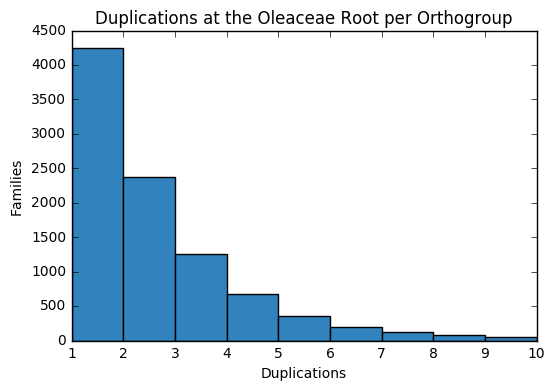

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import log
fig, ax = plt.subplots()
ax.bar([1,2,3,4,5,6,7,8,9], heights, width=1, color='#3182bd')
ax.set_title("Duplications at the Oleaceae Root per Orthogroup")
ax.set_xlabel("Duplications")
ax.set_ylabel("Families")

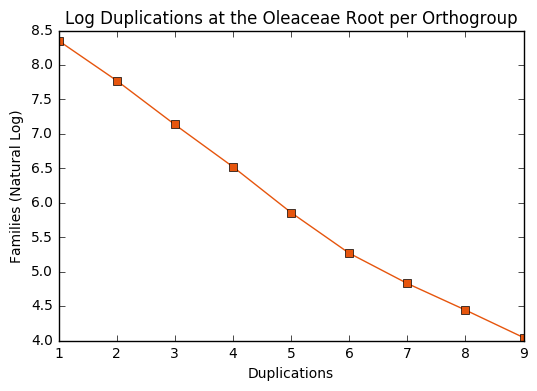

In [22]:
fig, ax = plt.subplots()
ax.plot([1,2,3,4,5,6,7,8,9], [log(h) for h in heights], 's-', color='#e6550d')
ax.set_title("Log Duplications at the Oleaceae Root per Orthogroup")
ax.set_xlabel("Duplications")
ax.set_ylabel("Families (Natural Log)")

In [23]:
ratios = []
for i, h in enumerate(heights):
    if i:
        print(round(h / heights[i-1] , 2))
        ratios.append(h / heights[i-1])
        if not h:
            break
import statistics
statistics.mean(ratios[:5])

0.56
0.53
0.54
0.51
0.55
0.64
0.68
0.67


0.5398277803614446

In [24]:
statistics.pstdev(ratios[:8])

0.06269242664855937

In [25]:
sum([h for h in heights])

9366

**Conclusion** That is eerily close to a perfectly straight line on the log scale.  The chance of seeing N+1 duplication events is a percentage of the previous number.

In [26]:
internal_mentions = defaultdict(lambda: 0)
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        if line['Species Tree Node'].startswith('N'):  # count mentions of anything not a species
            internal_mentions[line['Orthogroup']] += 1

len(internal_mentions)

16371

In [27]:
OG_names = set()
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        OG_names.add(line['Orthogroup'])
len(OG_names)

19118

**Conclusion** 85% of OGs with a duplication have an internal duplication.  49.9% of them mention N1.  22% have one duplication there, 2377+4242 = 34% of them have 1 or 2 duplications at N1.  There's still twice as many with 1 than 2.  I would need Jasmine to separate the two categories.  

# Separate out Study Homeologs into pairs of trees

In [55]:
study_homeologs = [og for og, c in N1_counts.items() if c >= 6]
len(study_homeologs), study_homeologs[:5]

(641, ['OG0002497', 'OG0008458', 'OG0002561', 'OG0002608', 'OG0000815'])

In [56]:
' '.join(study_homeologs)

'OG0002497 OG0008458 OG0002561 OG0002608 OG0000815 OG0000943 OG0002597 OG0003586 OG0001463 OG0002274 OG0000548 OG0005913 OG0000562 OG0000227 OG0003278 OG0000253 OG0000497 OG0000037 OG0001186 OG0000140 OG0000241 OG0002778 OG0007889 OG0000094 OG0003501 OG0000139 OG0000034 OG0000210 OG0000015 OG0000999 OG0000547 OG0003476 OG0000143 OG0000493 OG0001394 OG0000556 OG0000607 OG0001854 OG0002703 OG0000216 OG0003289 OG0000188 OG0000678 OG0000294 OG0002896 OG0000307 OG0000105 OG0000549 OG0003258 OG0002341 OG0008273 OG0005840 OG0009376 OG0000902 OG0000028 OG0002091 OG0006349 OG0008183 OG0000131 OG0000184 OG0000411 OG0000532 OG0000407 OG0000590 OG0000251 OG0001325 OG0000354 OG0006728 OG0000741 OG0001055 OG0002457 OG0007783 OG0000148 OG0000077 OG0002553 OG0000050 OG0009175 OG0000265 OG0004970 OG0000276 OG0003434 OG0000442 OG0001182 OG0002652 OG0002052 OG0001395 OG0000936 OG0009329 OG0002958 OG0000117 OG0002381 OG0000271 OG0000588 OG0002083 OG0000580 OG0001505 OG0001797 OG0000426 OG0001077 OG0000394

In [51]:
len('OG0008564 OG0006409 OG0010456 OG0006242 OG0004969 OG0010482 OG0005033 OG0003692 OG0005881 OG0001948 OG0004133 OG0012357 OG0011659 OG0007081 OG0009608 OG0006675 OG0005222 OG0006616 OG0008568 OG0004130 OG0010672 OG0003661 OG0006745 OG0009333 OG0012745 OG0009440 OG0001520 OG0006730 OG0009493 OG0013618 OG0003987 OG0019893 OG0008493 OG0009098 OG0003266 OG0017410 OG0016462 OG0010090 OG0011083 OG0006923 OG0006472 OG0009159 OG0005690 OG0008946 OG0005634 OG0006612 OG0005736 OG0006340 OG0008690 OG0008586 OG0005900 OG0010968 OG0004850 OG0008960 OG0005450 OG0012085 OG0011280 OG0010095 OG0004413 OG0005524 OG0018515 OG0005392 OG0016981 OG0005917 OG0008612 OG0014492 OG0012065 OG0002970 OG0014637 OG0007474 OG0010421 OG0004720 OG0005565 OG0003954 OG0003555 OG0007893 OG0010861 OG0015721 OG0009906 OG0004278 OG0003139 OG0007427 OG0005472 OG0006275 OG0004272 OG0010045 OG0011461 OG0006751 OG0008522 OG0005172 OG0009642 OG0009651 OG0006698 OG0007399 OG0018789 OG0006805 OG0005010 OG0004905 OG0005644 OG0004000 OG0008357 OG0010219 OG0008992 OG0009138 OG0013409 OG0003184 OG0005942 OG0004871 OG0006603 OG0005170 OG0018982 OG0009334 OG0022799 OG0008648 OG0010853 OG0005325 OG0020276 OG0002302 OG0004225 OG0005810 OG0010234 OG0008559 OG0010808 OG0007400 OG0007504 OG0012510 OG0008348 OG0005616 OG0005316 OG0006799 OG0013139 OG0007588 OG0007698 OG0018989 OG0003357 OG0013823 OG0008814 OG0004774 OG0002669 OG0004816 OG0007758 OG0006680 OG0008242 OG0007141 OG0007253 OG0008217 OG0016669 OG0018030 OG0008799 OG0008520 OG0004728 OG0002525 OG0008944 OG0009561 OG0009662 OG0007613 OG0000304 OG0015118 OG0011159 OG0005013 OG0008760 OG0003058 OG0002735 OG0010645 OG0003569 OG0001869 OG0005311 OG0002817 OG0012060 OG0006191 OG0016793 OG0010356 OG0005298 OG0006715 OG0005111 OG0008973 OG0010000 OG0007224 OG0010847 OG0007189 OG0006028 OG0003904 OG0006967 OG0007230 OG0009131 OG0016636 OG0002230 OG0004022 OG0007030 OG0009241 OG0002265 OG0006931 OG0007633 OG0013051 OG0003779 OG0009487 OG0003855 OG0012848 OG0007212 OG0012892 OG0001449 OG0014118 OG0009361 OG0004806 OG0004654 OG0001970 OG0004912 OG0019309 OG0006253 OG0007803 OG0004331 OG0003612 OG0003664 OG0008687 OG0009016 OG0010106 OG0002978 OG0019902 OG0005860 OG0011575 OG0009519 OG0005824 OG0008272 OG0010198 OG0007547 OG0002148 OG0007988 OG0006641 OG0018923 OG0011223 OG0007355 OG0009770 OG0004577 OG0005223 OG0004772 OG0008283 OG0004624 OG0005456 OG0004300 OG0002517 OG0001764 OG0007637 OG0004903 OG0008475 OG0005926 OG0009744 OG0010721 OG0004218 OG0003283 OG0007301 OG0005095 OG0012476 OG0010276 OG0006025 OG0008864 OG0004510 OG0008982 OG0009518 OG0006450 OG0008836 OG0004005 OG0000013 OG0006314 OG0007647 OG0011272 OG0009891 OG0004812 OG0005630 OG0006865 OG0018900 OG0004734 OG0020737 OG0016313 OG0018157 OG0006447 OG0020721 OG0011990 OG0006347 OG0007120 OG0019082 OG0007071 OG0008481 OG0013624 OG0019007 OG0008209 OG0009312 OG0006498 OG0018702 OG0017525 OG0005254 OG0010105 OG0011607 OG0006915 OG0003535 OG0005526 OG0008580 OG0010016 OG0006341 OG0007541 OG0004617 OG0012179 OG0011867 OG0001525 OG0006060 OG0001328 OG0007205 OG0009848 OG0017754 OG0006810 OG0005395 OG0008477 OG0004980 OG0006170 OG0007994 OG0010613 OG0007779 OG0011138 OG0006302 OG0012369 OG0010439 OG0004824 OG0010476 OG0007317 OG0001753 OG0007676 OG0008528 OG0007848 OG0010730 OG0006537 OG0008774 OG0001742 OG0004693 OG0003352 OG0005212 OG0013646 OG0006422 OG0008535 OG0003013 OG0004873 OG0008577 OG0001981 OG0009080 OG0008529 OG0005509 OG0004710 OG0009321 OG0004608 OG0007278 OG0004652 OG0005976 OG0012237 OG0009733 OG0004065 OG0012956 OG0008218 OG0003381 OG0008545 OG0007916 OG0005040 OG0010873 OG0000716 OG0004249 OG0002737 OG0008388 OG0007870 OG0004983 OG0005799 OG0007700 OG0011094 OG0011433 OG0011237 OG0005694 OG0009343 OG0013705 OG0017328 OG0005919 OG0004131 OG0007665 OG0010767 OG0011045 OG0005069 OG0005482 OG0007004 OG0009443 OG0006849 OG0006978 OG0004918 OG0018692 OG0009235 OG0003863 OG0012700 OG0006788 OG0006047 OG0008311 OG0011066 OG0005952 OG0003457 OG0007996 OG0008133 OG0011048 OG0006909 OG0001954 OG0006598 OG0006650 OG0005957 OG0005916 OG0013219 OG0000612 OG0002665 OG0006801 OG0015729 OG0008837 OG0005037 OG0005058 OG0001503 OG0006232 OG0010859 OG0005177 OG0004338 OG0017000 OG0008895 OG0018500 OG0000491 OG0013346 OG0006175 OG0003134 OG0010404 OG0000751 OG0008340 OG0006627 OG0010457 OG0009254 OG0006970 OG0010491 OG0006419 OG0001020 OG0007201 OG0012050 OG0005751 OG0010115 OG0010263 OG0011403 OG0008480 OG0005973 OG0008827 OG0010038 OG0003774 OG0009366 OG0009586 OG0012658 OG0019622 OG0008402 OG0005861 OG0007795 OG0013891 OG0006098 OG0011695 OG0007598 OG0010428 OG0012215 OG0005224 OG0004985 OG0007026 OG0007556 OG0016702 OG0000391 OG0001557 OG0016538 OG0010433 OG0001774 OG0004705 OG0009377 OG0013431 OG0008891 OG0007949 OG0019450 OG0007064 OG0009719 OG0007999 OG0005585 OG0001350 OG0001917 OG0010887 OG0005940 OG0011571 OG0015792 OG0008058 OG0010423 OG0011373 OG0003234 OG0007245 OG0004505 OG0005026 OG0004371 OG0002280 OG0011547 OG0008561 OG0010284 OG0004954 OG0011920 OG0006257 OG0004180 OG0006636 OG0002356 OG0002106 OG0002952 OG0011678 OG0003711 OG0007484 OG0008471 OG0006240 OG0010120 OG0011875 OG0001783 OG0009401 OG0011791 OG0007265 OG0008302 OG0017184 OG0003055 OG0006109 OG0011235 OG0010083 OG0012007 OG0006510 OG0005909 OG0012440 OG0005444 OG0005867 OG0009839 OG0014861 OG0008546 OG0006543 OG0011760 OG0011393 OG0005989 OG0007359 OG0010913 OG0006864 OG0018139 OG0012894 OG0009784 OG0007963 OG0009102 OG0007172 OG0004939 OG0001615 OG0009841 OG0006249 OG0022667 OG0017945 OG0008186 OG0013298 OG0015254 OG0011781 OG0008055 OG0016698 OG0004099 OG0008714 OG0011404 OG0002035 OG0009653 OG0014619 OG0008771 OG0018010 OG0006206 OG0006235 OG0002708 OG0012155 OG0010910 OG0008114 OG0006305 OG0005555 OG0005577 OG0008198 OG0008459 OG0010277 OG0005492 OG0001193 OG0011140 OG0003798 OG0005662 OG0004657 OG0003413 OG0012386 OG0006365 OG0015525 OG0002961 OG0010615 OG0003878 OG0007207 OG0007507 OG0001056 OG0004042 OG0008552 OG0001455 OG0004853 OG0012926 OG0009320 OG0006163 OG0010927 OG0008119 OG0009797 OG0006647 OG0005663 OG0008011 OG0008573 OG0008003 OG0009278 OG0005560 OG0001950 OG0002888 OG0007054 OG0017938 OG0004456 OG0003185 OG0005252 OG0008245 OG0016251 OG0012791 OG0007828 OG0005073 OG0012238 OG0008295 OG0003135 OG0005374 OG0002161 OG0008818 OG0004981 OG0007472 OG0007527 OG0009752 OG0008898 OG0012746 OG0004575 OG0019496 OG0002769 OG0005959 OG0011670 OG0013737 OG0010047 OG0008030 OG0010172 OG0010462 OG0008288 OG0002249 OG0002016 OG0005203 OG0008437 OG0007687 OG0008720 OG0018945 OG0003655 OG0000069 OG0010817 OG0004993 OG0007434 OG0004303 OG0004054 OG0008276 OG0003946 OG0004159 OG0007905 OG0014806 OG0013964 OG0008525 OG0008752 OG0009757 OG0006867 OG0003562 OG0013861 OG0001321 OG0004301 OG0008073 OG0002204 OG0018771 OG0009576 OG0009603 OG0012430 OG0004204 OG0012145 OG0007098 OG0008306 OG0001090 OG0009486 OG0019657 OG0011000 OG0008232 OG0004890 OG0007983 OG0004182 OG0003306 OG0018569 OG0012266 OG0007591 OG0005836 OG0008286 OG0005540 OG0017288 OG0002898 OG0009227 OG0007912 OG0016552 OG0006034 OG0008789 OG0020464 OG0004966 OG0010539 OG0017106 OG0006004 OG0009993 OG0013733 OG0010608 OG0008294 OG0004574 OG0007513 OG0003463 OG0006041 OG0007981 OG0021342 OG0012069 OG0015950 OG0019456 OG0009100 OG0009920 OG0005880 OG0006399 OG0007573 OG0017282 OG0010597 OG0004689 OG0004943 OG0009766 OG0001087 OG0008401 OG0006481 OG0006954 OG0004889 OG0005169 OG0013966 OG0003115 OG0005682 OG0007928 OG0006814 OG0009126 OG0007986 OG0005192 OG0003053 OG0007632 OG0001642 OG0009625 OG0015914 OG0009799 OG0006833 OG0004615 OG0004606 OG0008730 OG0006656 OG0010340 OG0010230 OG0004893 OG0009179 OG0005626 OG0007406 OG0004345 OG0007369 OG0017806 OG0006831 OG0011617 OG0001135 OG0004769 OG0004077 OG0013502 OG0006684 OG0004472 OG0013731 OG0007945 OG0006123 OG0007342 OG0007516 OG0008121 OG0004380 OG0002209 OG0016575 OG0001376 OG0008457 OG0004783 OG0008988 OG0017027 OG0003925 OG0002445 OG0004292 OG0004725 OG0005362 OG0002790 OG0016952 OG0003832 OG0011834 OG0016311 OG0004998 OG0010299 OG0006286 OG0001877 OG0006655 OG0006602 OG0010923 OG0010401 OG0004664 OG0009180 OG0010478 OG0005399 OG0004284 OG0011270 OG0018225 OG0007847 OG0002825 OG0006476 OG0010669 OG0006252 OG0008448 OG0000334 OG0006212 OG0001780 OG0010390 OG0005071 OG0009303 OG0002070 OG0005949 OG0009824 OG0009373 OG0007348 OG0006786 OG0014345 OG0006560 OG0011540 OG0013208 OG0001429 OG0008877 OG0007351 OG0009503 OG0004381 OG0001633 OG0001709 OG0004951 OG0006776 OG0010093 OG0011115 OG0006379 OG0007035 OG0004938 OG0019784 OG0005510 OG0002362 OG0005945 OG0011570 OG0013132 OG0018207 OG0011123 OG0009501 OG0005809 OG0008364 OG0017245 OG0010288 OG0009749 OG0004866 OG0014097 OG0013379 OG0002155 OG0006798 OG0002723 OG0004450 OG0007639 OG0003028 OG0002954 OG0004280 OG0002500 OG0007425 OG0015573 OG0015879 OG0009963 OG0007494 OG0007619 OG0006755 OG0008160 OG0019104 OG0003272 OG0008254 OG0003888 OG0017406 OG0017813 OG0007563 OG0003976 OG0001637 OG0004629 OG0006732 OG0004258 OG0000885 OG0007629 OG0008915 OG0006262 OG0001364 OG0008683 OG0007164 OG0000781 OG0005883 OG0009647 OG0005528 OG0011497 OG0007634 OG0013592 OG0007432 OG0010099 OG0001687 OG0007076 OG0005084 OG0011301 OG0013217 OG0020553 OG0012472 OG0006081 OG0002746 OG0013375 OG0007930 OG0009344 OG0005209 OG0008313 OG0006304 OG0008732 OG0006180 OG0006564 OG0008411 OG0005344 OG0015036 OG0004929 OG0005557 OG0010646 OG0004879 OG0004984 OG0011849 OG0015266 OG0011322 OG0007186 OG0003173 OG0008164 OG0014682 OG0002831 OG0006515 OG0006765 OG0005676 OG0006870 OG0007326 OG0006248 OG0013376 OG0006208 OG0008761 OG0003506 OG0010970 OG0006629 OG0017342 OG0006278 OG0003103 OG0011038 OG0004347 OG0006744 OG0000784 OG0002551 OG0008727 OG0018469 OG0007807 OG0003601 OG0011420 OG0012797 OG0004782 OG0015291 OG0015300 OG0009447 OG0016540 OG0002331 OG0007257 OG0004747 OG0007904 OG0009010 OG0007776 OG0003307 OG0018024 OG0005042 OG0006521 OG0007455 OG0012618 OG0006782 OG0007107 OG0009721 OG0017744 OG0013412 OG0012718 OG0002673 OG0004651 OG0007185 OG0002534 OG0007008 OG0009266 OG0012174 OG0005140 OG0002806 OG0000655 OG0001212 OG0006058 OG0005131 OG0004078 OG0007452 OG0004623 OG0017606 OG0010903 OG0016529 OG0007914 OG0012305 OG0018825 OG0007964 OG0015913 OG0007909 OG0004564 OG0009079 OG0017863 OG0004677 OG0005360 OG0002183 OG0009122 OG0001380 OG0004605 OG0010747 OG0005769 OG0009694 OG0005578 OG0011848 OG0006600 OG0006386 OG0007911 OG0004448 OG0006287 OG0006523 OG0005534 OG0006835 OG0004318 OG0007082 OG0013552 OG0005598 OG0003245 OG0008598 OG0006852 OG0004396 OG0004455 OG0009617 OG0016834 OG0018846 OG0017482 OG0010101 OG0007932 OG0011560 OG0007042 OG0004830 OG0004339 OG0010150 OG0009220 OG0018700 OG0012210 OG0003101 OG0009111 OG0009868 OG0004076 OG0010496 OG0020636 OG0007308 OG0010294 OG0007624 OG0006271 OG0007243 OG0008032 OG0008579 OG0004660 OG0011219 OG0006651 OG0011162 OG0004525 OG0001666 OG0011847 OG0005113 OG0011915 OG0016785 OG0004474 OG0007969 OG0004499 OG0009001 OG0008503 OG0010611 OG0010588 OG0007277 OG0001967 OG0012296 OG0010502 OG0006825 OG0010839 OG0002915 OG0006019 OG0001547 OG0007918 OG0003822 OG0006160 OG0005281 OG0005384 OG0006056 OG0011356 OG0007892 OG0009219 OG0004908 OG0003971 OG0009263 OG0006418 OG0007273 OG0002850 OG0017310 OG0008578 OG0010293 OG0007572 OG0005379 OG0006513 OG0005297 OG0005232 OG0011730 OG0009265 OG0001418 OG0010086 OG0009154 OG0014157 OG0012247 OG0004326 OG0004659 OG0004408 OG0008222 OG0007403 OG0005060 OG0015012 OG0012987 OG0004354 OG0018056 OG0009247 OG0004770 OG0000138 OG0004778 OG0018253 OG0002697 OG0009075 OG0015897 OG0014727 OG0006735 OG0008688 OG0004205 OG0010065 OG0010551 OG0020234 OG0009886 OG0001617 OG0006986 OG0009489 OG0009086 OG0003368 OG0016857 OG0006758 OG0011800 OG0011604 OG0002640 OG0005167 OG0007146 OG0007331 OG0018049 OG0005920 OG0004250 OG0014554 OG0006446 OG0008169 OG0008948 OG0005830 OG0010868 OG0011464 OG0006255 OG0006332 OG0012806 OG0007569 OG0000877 OG0010068 OG0017986 OG0011451 OG0008324 OG0017521 OG0006118 OG0020710 OG0003098 OG0003172 OG0006816 OG0002164 OG0003219 OG0007530 OG0004146 OG0006295 OG0013938 OG0001304 OG0014359 OG0013012 OG0003972 OG0008126 OG0008967 OG0003543 OG0008408 OG0007344 OG0007596 OG0004638 OG0011552 OG0007908 OG0000638 OG0010365 OG0004964 OG0007412 OG0001467 OG0007600 OG0008936 OG0009371 OG0011946 OG0001939 OG0000587 OG0007037 OG0013594 OG0002270 OG0007782 OG0009475 OG0007926 OG0017195 OG0005895 OG0008739 OG0010225 OG0007316 OG0013692 OG0005284 OG0003873 OG0016819 OG0006093 OG0012194 OG0004420 OG0006161 OG0004171 OG0012136 OG0002889 OG0006174 OG0018092 OG0003833 OG0010084 OG0006927 OG0006702 OG0009527 OG0020272 OG0016611 OG0005148 OG0003222 OG0009162 OG0006375 OG0016612 OG0003119 OG0000659 OG0001536 OG0003148 OG0004561 OG0005403 OG0008651 OG0009545 OG0002785 OG0007967 OG0005333 OG0009946 OG0008740 OG0007561 OG0000463 OG0005939 OG0014004 OG0010021 OG0002458 OG0004922 OG0009148 OG0004121 OG0004558 OG0017457 OG0007498 OG0008537 OG0006644 OG0017648 OG0004992 OG0018146 OG0008755 OG0001442 OG0006796 OG0004860 OG0004378 OG0010220 OG0011204 OG0010278 OG0011286 OG0007334 OG0009450 OG0006042 OG0007953 OG0017267 OG0013919 OG0004994 OG0004220 OG0009948 OG0003915 OG0000212 OG0005544 OG0009185 OG0009169 OG0005784 OG0009041 OG0004727 OG0006960 OG0007223 OG0001522 OG0010139 OG0007349 OG0010554 OG0003565 OG0005687 OG0006957 OG0001036 OG0004033 OG0007404 OG0000622 OG0004986 OG0001507 OG0009172 OG0007149 OG0016594 OG0000838 OG0006467 OG0004737 OG0012879 OG0006383 OG0012273 OG0007796 OG0010920 OG0011369 OG0007411 OG0010752 OG0008937 OG0013808 OG0004942 OG0011120 OG0007688 OG0007859 OG0012990 OG0012267 OG0004719 OG0004872 OG0007044 OG0005251 OG0008736 OG0010991 OG0007681 OG0004208 OG0009790 OG0003857 OG0008170 OG0006227 OG0010540 OG0006953 OG0003619 OG0010366 OG0010320 OG0006737 OG0003361 OG0008410 OG0005627 OG0006083 OG0011034 OG0007211 OG0003934 OG0011952 OG0014994 OG0008082 OG0013703 OG0004934 OG0018511 OG0009042 OG0001070 OG0005151 OG0012186 OG0021601 OG0004902 OG0009851 OG0008764 OG0007393 OG0005152 OG0003677 OG0007592 OG0004234 OG0008069 OG0008700 OG0004960 OG0009634 OG0007972 OG0010801 OG0007375 OG0004034 OG0005873 OG0007770 OG0000721 OG0011182 OG0002576 OG0004210 OG0008694 OG0006211 OG0005503 OG0010237 OG0005843 OG0012144 OG0011711 OG0010371 OG0007362 OG0006921 OG0005831 OG0004593 OG0012078 OG0009314 OG0007844 OG0005968 OG0009481 OG0005511 OG0004761 OG0009555 OG0000927 OG0003528 OG0004989 OG0017991 OG0014279 OG0017649 OG0010385 OG0010820 OG0004156 OG0005376 OG0005418 OG0007005 OG0008703 OG0006592 OG0004423 OG0005183 OG0008454 OG0012639 OG0014002 OG0003355 OG0005518 OG0019682 OG0008697 OG0006625 OG0010488 OG0011390 OG0017241 OG0014026 OG0004641 OG0010630 OG0009103 OG0005910 OG0006677 OG0013124 OG0008159 OG0005908 OG0006671 OG0005604 OG0010176 OG0021109 OG0007594 OG0009531 OG0006974 OG0008747 OG0003682 OG0007506 OG0004626 OG0007454 OG0006455 OG0015575 OG0019790 OG0013175 OG0012140 OG0007696 OG0005088 OG0004188 OG0011565 OG0006935 OG0015536 OG0009048 OG0007760 OG0005688 OG0006282 OG0005991 OG0004245 OG0006066 OG0006131 OG0011913 OG0016092 OG0007339 OG0018193 OG0006017 OG0005835 OG0006142 OG0009732 OG0006905 OG0004290 OG0014072 OG0006448 OG0008375 OG0014622 OG0010585 OG0016746 OG0010598 OG0006336 OG0003917 OG0013066 OG0008314 OG0009568 OG0003830 OG0004340 OG0005794 OG0004899 OG0007062 OG0011080 OG0011505 OG0007534 OG0006977 OG0010559 OG0011512 OG0015146 OG0006551 OG0006756 OG0011943 OG0003257 OG0010152 OG0018556 OG0011018 OG0005655 OG0008021 OG0006192 OG0004865 OG0000473 OG0010304 OG0006944 OG0009713 OG0010209 OG0017030 OG0008017 OG0008772 OG0010803 OG0005031 OG0010569 OG0006075 OG0005781 OG0010529 OG0006162 OG0004794 OG0006502 OG0007712 OG0009384 OG0015741 OG0021293 OG0010202 OG0010556 OG0009012 OG0011082 OG0009043 OG0006906 OG0005004 OG0006623 OG0003417 OG0009317 OG0008162 OG0010944 OG0003663 OG0014607 OG0008902 OG0004883 OG0011735 OG0011092 OG0009276 OG0014130 OG0004692 OG0009004 OG0014241 OG0006281 OG0007051 OG0003325 OG0008762 OG0005660 OG0006414 OG0009470 OG0003634 OG0016055 OG0005234 OG0001286 OG0004800 OG0005476 OG0002182 OG0006503 OG0008195 OG0005859 OG0005600 OG0007869 OG0003465 OG0010794 OG0007680 OG0005099 OG0005416 OG0009217 OG0005176 OG0015557 OG0002773 OG0006437 OG0010239 OG0004194 OG0003983 OG0006068 OG0012751 OG0004607 OG0005551 OG0013853 OG0006048 OG0002465 OG0004676 OG0001396 OG0004877 OG0012898 OG0001922 OG0004230 OG0006064 OG0006119 OG0019886 OG0008726 OG0006949 OG0006509 OG0004518 OG0011062 OG0003761 OG0008307 OG0006130 OG0008049 OG0015160 OG0012055 OG0005380 OG0005776 OG0001757 OG0015201 OG0005218 OG0018131 OG0020856 OG0004255 OG0005055 OG0002278 OG0007387 OG0006681 OG0004075 OG0004532 OG0012177 OG0007985 OG0009408 OG0010031 OG0008077 OG0006307 OG0003848 OG0004382 OG0009066 OG0011892 OG0005713 OG0006261 OG0009530 OG0013504 OG0003060 OG0007965 OG0002599 OG0003881 OG0015836 OG0010999 OG0008875 OG0004898 OG0002667 OG0014234 OG0019788 OG0004795 OG0007049 OG0006250 OG0012972 OG0009960 OG0005493 OG0009535 OG0008893 OG0018437 OG0005340 OG0009762 OG0013490 OG0001420 OG0008258 OG0007415 OG0002377 OG0009550 OG0006595 OG0016831 OG0003680 OG0003788 OG0009088 OG0006597 OG0004781 OG0011933 OG0016391 OG0005359 OG0006203 OG0008341 OG0003793 OG0008784 OG0005002 OG0011049 OG0011825 OG0006463 OG0006661 OG0002232 OG0007978 OG0008542 OG0007586 OG0001283 OG0009141 OG0009592 OG0005035 OG0004674 OG0011647 OG0014357 OG0003738 OG0005504 OG0017253 OG0008163 OG0007329 OG0005471 OG0004438 OG0005036 OG0012883 OG0009908 OG0012016 OG0007069 OG0002273 OG0009969 OG0003836 OG0016875 OG0009726 OG0016768 OG0004516 OG0007938 OG0012860 OG0009580 OG0007209 OG0009387 OG0011865 OG0004106 OG0003598 OG0001257 OG0005125 OG0006881 OG0004282 OG0005685 OG0008544 OG0008265 OG0008822 OG0008631 OG0008713 OG0004668 OG0006078 OG0006648 OG0016903 OG0010353 OG0011688 OG0010832 OG0008829 OG0010950 OG0009209 OG0008884 OG0005892 OG0008553 OG0004636 OG0004754 OG0006565 OG0003737 OG0006381 OG0004071 OG0004679 OG0009622 OG0008518 OG0011529 OG0007341 OG0004936 OG0006795 OG0009502 OG0016164 OG0001809 OG0008084 OG0008869 OG0004216 OG0019378 OG0007901 OG0006573 OG0012445 OG0006176 OG0007873 OG0018377 OG0011108 OG0009573 OG0006624 OG0009700 OG0003933 OG0009304 OG0002007 OG0005807 OG0002036 OG0007161 OG0003672 OG0006117 OG0007345 OG0007937 OG0014690 OG0012317 OG0010690 OG0005424 OG0004404 OG0009582 OG0003373 OG0004355 OG0002580 OG0005719 OG0011224 OG0004155 OG0016044 OG0011256 OG0005022 OG0011618 OG0006070 OG0010902 OG0002030 OG0000609 OG0015531 OG0007390 OG0005263 OG0002590 OG0005821 OG0004941 OG0004503 OG0006578 OG0011088 OG0005077 OG0003532 OG0007439 OG0016860 OG0007151 OG0005981 OG0010553 OG0002641 OG0009918 OG0017816 OG0013704 OG0006902 OG0002863 OG0004478 OG0006339 OG0001464 OG0007389 OG0005888 OG0006215 OG0007252 OG0006233 OG0009190 OG0007043 OG0010058 OG0005559 OG0007087 OG0000979 OG0017349 OG0008667 OG0008904 OG0002876 OG0008018 OG0014315 OG0007536 OG0007491 OG0005490 OG0005761 OG0006256 OG0007476 OG0006701 OG0006939 OG0006354 OG0006734 OG0008188 OG0019404 OG0005260 OG0010736 OG0007722 OG0006194 OG0000628 OG0011460 OG0007922 OG0013831 OG0003553 OG0002812 OG0005773 OG0004580 OG0004435 OG0007089 OG0004625 OG0004944 OG0009025 OG0006885 OG0004480 OG0002496 OG0005608 OG0017517 OG0003931 OG0010403 OG0010933 OG0006121 OG0007163 OG0018391 OG0002885 OG0005097 OG0007858 OG0006781 OG0004619 OG0006151 OG0010303 OG0010756 OG0011165 OG0005521 OG0006842 OG0001485 OG0006527 OG0006317 OG0005135 OG0005988 OG0008462 OG0000799 OG0001802 OG0011070 OG0007283 OG0007391 OG0011879 OG0000617 OG0004364 OG0005764 OG0005576 OG0004356 OG0005431 OG0005980 OG0007022 OG0005445 OG0012032 OG0006888 OG0017165 OG0005609 OG0006508 OG0007794 OG0004536 OG0018876 OG0005261 OG0006344 OG0008395 OG0006665 OG0019294 OG0009072 OG0006040 OG0007453 OG0001765 OG0005481 OG0010364 OG0002169 OG0005588 OG0011387 OG0009129 OG0004663 OG0005143 OG0009385 OG0007942 OG0004466 OG0007096 OG0005734 OG0011302 OG0011687 OG0005480 OG0009816 OG0008975 OG0005905 OG0013589 OG0005842 OG0004950 OG0004017 OG0011523 OG0008497 OG0007657 OG0008658 OG0006783 OG0005494 OG0003997 OG0017576 OG0005046 OG0006662 OG0003089 OG0010785 OG0001402 OG0004508 OG0013790 OG0013093 OG0015785 OG0006138 OG0009614 OG0008917 OG0020620 OG0015793 OG0008600 OG0002254 OG0006617 OG0016070 OG0006370 OG0007725 OG0003195 OG0004164 OG0004050 OG0006958 OG0000986 OG0019299 OG0013792 OG0003081 OG0014772 OG0005079 OG0008019 OG0016156 OG0011873 OG0003752 OG0008811 OG0008293 OG0004622 OG0006348 OG0002409 OG0001229 OG0013694 OG0008925 OG0005850 OG0003335 OG0011511 OG0010514 OG0001069 OG0008063 OG0014094 OG0010947 OG0004704 OG0008440 OG0010864 OG0008562 OG0013294 OG0003254 OG0004945 OG0004344 OG0009751 OG0008843 OG0006475 OG0001343 OG0008391 OG0005817 OG0007014 OG0018940 OG0003123 OG0006456 OG0015704 OG0007992 OG0018594 OG0004716 OG0006376 OG0010626 OG0008012 OG0005711 OG0004687 OG0010504 OG0002484 OG0009880 OG0003748 OG0004056 OG0005681 OG0004775 OG0002239 OG0006371 OG0008971 OG0002065 OG0005782 OG0008758 OG0004405 OG0006987 OG0005633 OG0017929 OG0009575 OG0013443 OG0004385 OG0002687 OG0007373 OG0009212 OG0011900 OG0003419 OG0016582 OG0006736 OG0005000 OG0004416 OG0010503 OG0003252 OG0011061 OG0005245 OG0007627 OG0002171 OG0005117 OG0009146 OG0005902 OG0007906 OG0006424 OG0013773 OG0006311 OG0011004 OG0012436 OG0012648 OG0010700 OG0016333 OG0007902 OG0005112 OG0005061 OG0020536 OG0006739 OG0005948 OG0010699 OG0011958 OG0010321 OG0003366 OG0009336 OG0014723 OG0005477 OG0011212 OG0003859 OG0009331 OG0010466 OG0008783 OG0005978 OG0010885 OG0001656 OG0015357 OG0011942 OG0006951 OG0010813 OG0010516 OG0012398 OG0017024 OG0002880 OG0001852 OG0004595 OG0001303 OG0014046 OG0018743 OG0005619 OG0002942 OG0008675 OG0003550 OG0002467 OG0003078 OG0008949 OG0006743 OG0002255 OG0003299 OG0004765 OG0003897 OG0008065 OG0009420 OG0006434 OG0007704 OG0008464 OG0009052 OG0010452 OG0002674 OG0008955 OG0001171 OG0003309 OG0009140 OG0003090 OG0010627 OG0011914 OG0002660 OG0009840 OG0013506 OG0011863 OG0007878 OG0007744 OG0016833 OG0000740 OG0007437 OG0005591 OG0015048 OG0012484 OG0009345 OG0007343 OG0008931 OG0012166 OG0006966 OG0004900 OG0006566 OG0010827 OG0021789 OG0003274 OG0006210 OG0009222 OG0009747 OG0012353 OG0008926 OG0008841 OG0012810 OG0007966 OG0004961 OG0007742 OG0009163 OG0012611 OG0016559 OG0003945 OG0007480 OG0005848 OG0003768 OG0000398 OG0003076 OG0008887 OG0004293 OG0004649 OG0007242 OG0005779 OG0010962 OG0002881 OG0007184 OG0007686 OG0006015 OG0004914 OG0006696 OG0010138 OG0012075 OG0016557 OG0004971 OG0004397 OG0019267 OG0009074 OG0008456 OG0007324 OG0009727 OG0006018 OG0011886 OG0003437 OG0003297 OG0005267 OG0007202 OG0004544 OG0008702 OG0008862 OG0002607 OG0005595 OG0003872 OG0006685 OG0007440 OG0011774 OG0009579 OG0009905 OG0006784 OG0008413 OG0008981 OG0004427 OG0007968 OG0003342 OG0006936 OG0018083 OG0010092 OG0003477 OG0010522 OG0002853 OG0000670 OG0004191 OG0005066 OG0007552 OG0007623 OG0010946 OG0007383 OG0003330 OG0005373 OG0005935 OG0000625 OG0011591 OG0016809 OG0006145 OG0013406 OG0007831 OG0003045 OG0005464 OG0002804 OG0003223 OG0010248 OG0004013 OG0013488 OG0005225 OG0008852 OG0007707 OG0005640 OG0004443 OG0012103 OG0002774 OG0004538 OG0012619 OG0005849 OG0006315 OG0011351 OG0014338 OG0009268 OG0017480 OG0006049 OG0017166 OG0011700 OG0010180 OG0009249 OG0007503 OG0011134 OG0004896 OG0006676 OG0004643 OG0001121 OG0007340 OG0013653 OG0002932 OG0021284 OG0009912 OG0006585 OG0017808 OG0006830 OG0004895 OG0002002 OG0005739 OG0004165 OG0006462 OG0009558 OG0004128 OG0008706 OG0003805 OG0018607 OG0019501 OG0019297 OG0008630 OG0004631 OG0006673 OG0008492 OG0006887 OG0008025 OG0018075 OG0005768 OG0014939 OG0017896 OG0012568 OG0014650 OG0003315 OG0009181 OG0008200 OG0008189 OG0019739 OG0018499 OG0002836 OG0005188 OG0017034 OG0003627 OG0009132 OG0004393 OG0013153 OG0003114 OG0011364 OG0012327 OG0007697 OG0007850 OG0004547 OG0003902 OG0009699 OG0008378 OG0011001 OG0018185 OG0012549 OG0007738 OG0011929 OG0005997 OG0004517 OG0009834 OG0006137 OG0008868 OG0009584 OG0005465 OG0017543 OG0007469 OG0009703 OG0001636 OG0009006 OG0004049 OG0007290 OG0002610 OG0012595 OG0003444 OG0008950 OG0005990 OG0009635 OG0006451 OG0003710 OG0021572 OG0005955 OG0011479 OG0002788 OG0005562 OG0008636 OG0018831 OG0008296 OG0005059 OG0013471 OG0015973 OG0010464 OG0006672 OG0001322 OG0004177 OG0017023 OG0005863 OG0007521 OG0005982 OG0011794 OG0002060 OG0010072 OG0010382 OG0002912 OG0011965 OG0006039 OG0010075 OG0002816 OG0011492 OG0009495 OG0007535 OG0010455 OG0000193 OG0011064 OG0003895 OG0019134 OG0013411 OG0007401 OG0001648 OG0003839 OG0007766 OG0001476 OG0010270 OG0006704 OG0007238 OG0013015 OG0007038 OG0013380 OG0007470 OG0005352 OG0008229 OG0011669 OG0017884 OG0008226 OG0007254 OG0005401 OG0011148 OG0007179 OG0006606 OG0005950 OG0014052 OG0003328 OG0010261 OG0013807 OG0006752 OG0005166 OG0007808 OG0005854 OG0015474 OG0009629 OG0001456 OG0006441 OG0006797 OG0019520 OG0021853 OG0015754 OG0004709 OG0011300 OG0007538 OG0005382 OG0006548 OG0004732 OG0011122 OG0011071 OG0003367 OG0007649 OG0007576 OG0016394 OG0005343 OG0004442 OG0009009 OG0007745 OG0010153 OG0010719 OG0004870 OG0020277 OG0010196 OG0007018 OG0011449 OG0003994 OG0010818 OG0009962 OG0008349 OG0007154 OG0009945 OG0004962 OG0014972 OG0009137 OG0002811 OG0012165 OG0011353 OG0005372 OG0011236 OG0013780 OG0005652 OG0003492 OG0005553 OG0005479 OG0010647 OG0007699 OG0002261 OG0008662 OG0012785 OG0006807 OG0007689 OG0011457 OG0007126 OG0008956 OG0008899 OG0003887 OG0010829 OG0009093 OG0007505 OG0004337 OG0000418 OG0010505 OG0009083 OG0007385 OG0006310 OG0011899 OG0008922 OG0004614 OG0017925 OG0007115 OG0006911 OG0004201 OG0008083 OG0006946 OG0005852 OG0004804 OG0009188 OG0007231 OG0000892 OG0018907 OG0007178 OG0009476 OG0010044 OG0005272 OG0012655 OG0007481 OG0010929 OG0001766 OG0009206 OG0012224 OG0002716 OG0006705 OG0013246 OG0005886 OG0010330 OG0009709 OG0004869 OG0022086 OG0002260 OG0005227 OG0003451 OG0001285 OG0009045 OG0000489 OG0006674 OG0012646 OG0004539 OG0010762 OG0008193 OG0007153 OG0006224 OG0018873 OG0007084 OG0006840 OG0004990 OG0003745 OG0015025 OG0015105 OG0007487 OG0002796 OG0001391 OG0017731 OG0002522 OG0012297 OG0004526 OG0003829 OG0005607 OG0008516 OG0004111 OG0006746 OG0017366 OG0008208 OG0007171 OG0014612 OG0004809 OG0005728 OG0011379 OG0006461 OG0007602 OG0001346 OG0011423 OG0005672 OG0006013 OG0004504 OG0008385 OG0017323 OG0005427 OG0004387 OG0011358 OG0014925 OG0001400 OG0008130 OG0016986 OG0004669 OG0010878 OG0009425 OG0019227 OG0006516 OG0003473 OG0006306 OG0006808 OG0007366 OG0008551 OG0005593 OG0004129 OG0004997 OG0010211 OG0022212 OG0008148 OG0011065 OG0012052 OG0005932 OG0014320 OG0007799 OG0006185 OG0011013 OG0002197 OG0004431 OG0013269 OG0007061 OG0008361 OG0006269 OG0007754 OG0001858 OG0011756 OG0004880 OG0004227 OG0003803 OG0014629 OG0010604 OG0012529 OG0003823 OG0010078 OG0002349 OG0006621 OG0007719 OG0008710 OG0004067 OG0006635 OG0001655 OG0009911 OG0003171 OG0011927 OG0010169 OG0008291 OG0012066 OG0005355 OG0014626 OG0005007 OG0006334 OG0004294 OG0003740 OG0004139 OG0003346 OG0005659 OG0004790 OG0004500 OG0001012 OG0008043 OG0007549 OG0017547 OG0009809 OG0011864 OG0007788 OG0008026 OG0002786 OG0010521 OG0002395 OG0013745 OG0008997 OG0007249 OG0020301 OG0003108 OG0007490 OG0017421 OG0018775 OG0006362 OG0004352 OG0008746 OG0007959 OG0004454 OG0004122 OG0012812 OG0010746 OG0008750 OG0001112 OG0011385 OG0006994 OG0005914 OG0004386 OG0005365 OG0005915 OG0004975 OG0003568 OG0007579 OG0007845 OG0005011 OG0004107 OG0015521 OG0007793 OG0004253 OG0007557 OG0011852 OG0009600 OG0010411 OG0007025 OG0010673 OG0017976 OG0012875 OG0007952 OG0002133 OG0001997 OG0008656 OG0003826 OG0007138 OG0005877 OG0006036 OG0012567 OG0003106 OG0007471 OG0009057 OG0010316 OG0006106 OG0014290 OG0007948 OG0007512 OG0000798 OG0002975 OG0005647 OG0006919 OG0003654 OG0008224 OG0012183 OG0005569 OG0005483 OG0004974 OG0008249 OG0006326 OG0007910 OG0004310 OG0007323 OG0003079 OG0006861 OG0009024 OG0008281 OG0007771 OG0008094 OG0005790 OG0006222 OG0009256 OG0005157 OG0006480 OG0011793 OG0006002 OG0004915 OG0005278 OG0006742 OG0004714 OG0006774 OG0014658 OG0014370 OG0009164 OG0002432 OG0009346 OG0011147 OG0006474 OG0007104 OG0010275 OG0008053 OG0004179 OG0013585 OG0009027 OG0017246 OG0011644 OG0005388 OG0007604 OG0011129 OG0006090 OG0004178 OG0008279 OG0009092 OG0006173 OG0008941 OG0009553 OG0007628 OG0005210 OG0001354 OG0009087 OG0005969 OG0008595 OG0003860 OG0005918 OG0007581 OG0003770 OG0016312 OG0005305 OG0009221 OG0008820 OG0004202 OG0011731 OG0009991 OG0005814 OG0009900 OG0003651 OG0006943 OG0005893 OG0005064 OG0005310 OG0003166 OG0002980 OG0005887 OG0008526 OG0009194 OG0007306 OG0009588 OG0015093 OG0011945 OG0006558 OG0010357 OG0000273 OG0018523 OG0006410 OG0004168 OG0009564 OG0005065 OG0005709 OG0008358 OG0020838 OG0005489 OG0004690 OG0009298 OG0009795 OG0005153 OG0009819 OG0003825 OG0005270 OG0002116 OG0010067 OG0012084 OG0010738 OG0000563 OG0008132 OG0011870 OG0007187 OG0005089 OG0010633 OG0005525 OG0005054 OG0009202 OG0009070 OG0004197 OG0011359 OG0006209 OG0005322 OG0005786 OG0006679 OG0005101 OG0018087 OG0006813 OG0007531 OG0009415 OG0010184 OG0005558 OG0005083 OG0006514 OG0001632 OG0014039 OG0003683 OG0003034 OG0011439 OG0010953 OG0003243 OG0007813 OG0001063 OG0004152 OG0003749 OG0004332 OG0012722 OG0004551 OG0017276 OG0022962 OG0010014 OG0004600 OG0006938 OG0003719 OG0008433 OG0007751 OG0015985 OG0008616 OG0002592 OG0003671 OG0011281 OG0010307 OG0004963 OG0003996 OG0004523 OG0006325 OG0006114 OG0006575 OG0008056 OG0012094 OG0004468 OG0019710 OG0004496 OG0008318 OG0010022 OG0005155 OG0005389 OG0004863 OG0005160 OG0005516 OG0000933 OG0007229 OG0014210 OG0006947 OG0006377 OG0003867 OG0011360 OG0006487 OG0008461 OG0012178 OG0009909 OG0010041 OG0009038 OG0008728 OG0004996 OG0011653 OG0009139 OG0004088 OG0006053 OG0004894 OG0015019 OG0009023 OG0000057 OG0010110 OG0013647 OG0005329 OG0007250 OG0008957 OG0013767 OG0004545 OG0011422 OG0004407 OG0011008 OG0012133 OG0003862 OG0001935 OG0005053 OG0008549 OG0010757 OG0008686 OG0010468 OG0012416 OG0005057 OG0003898 OG0007321 OG0015856 OG0007756 OG0010050 OG0018128 OG0018578 OG0010789 OG0017873 OG0001778 OG0008870 OG0004665 OG0011728 OG0009508 OG0009979 OG0008425 OG0011026 OG0007280 OG0009149 OG0006016 OG0007801 OG0011466 OG0004417 OG0007000 OG0003784 OG0012171 OG0001197 OG0006857 OG0010667 OG0009686 OG0001741 OG0019545 OG0006570 OG0010181 OG0008897 OG0004612 OG0010692 OG0003384 OG0002744 OG0012466 OG0002639 OG0009931 OG0015857 OG0016323 OG0000816 OG0011437 OG0011680 OG0002761 OG0007867 OG0009431 OG0003179 OG0007388 OG0005567 OG0007819 OG0002393 OG0017186 OG0006907 OG0001740 OG0011635 OG0011285 OG0007599 OG0006147 OG0012816 OG0006402 OG0004243 OG0008509 OG0006973 OG0013990 OG0006872 OG0007409 OG0012338 OG0007213 OG0010291 OG0006152 OG0005207 OG0009208 OG0004788 OG0006714 OG0006021 OG0007723 OG0004424 OG0007001 OG0005498 OG0021349 OG0004471 OG0005338 OG0008567 OG0005596 OG0004161 OG0007907 OG0002822 OG0008781 OG0014632 OG0005906 OG0005171 OG0005238 OG0007009 OG0010743 OG0001370 OG0009511 OG0006607 OG0001605 OG0007805 OG0005448 OG0008779 OG0003851 OG0011820 OG0004446 OG0001154 OG0016034 OG0003210 OG0003944 OG0008637 OG0002711 OG0005205 OG0007883 OG0017202 OG0011590 OG0006568 OG0005502 OG0009779 OG0019711 OG0004261 OG0005710 OG0009847 OG0019027 OG0012799 OG0004059 OG0017625 OG0009648 OG0006492 OG0009081 OG0006156 OG0007003 OG0010955 OG0001959 OG0007977 OG0007609 OG0006020 OG0004702 OG0005533 OG0018776 OG0004362 OG0012760 OG0007748 OG0003630 OG0004270 OG0005455 OG0008512 OG0009893 OG0004955 OG0009229 OG0013546 OG0009543 OG0009279 OG0007214 OG0007065 OG0007394 OG0007550 OG0006969 OG0002162 OG0002813 OG0019751 OG0003142 OG0011101 OG0012384 OG0001220 OG0005430 OG0008804 OG0017667 OG0007750 OG0000661 OG0007303 OG0004068 OG0003662 OG0007532 OG0004815 OG0006553 OG0008100 OG0007134 OG0001629 OG0004965 OG0003742 OG0014528 OG0010259 OG0003621 OG0004999 OG0010833 OG0007764 OG0005292 OG0003198 OG0009418 OG0005669 OG0011869 OG0011801 OG0017298 OG0006254 OG0005894 OG0006678 OG0005285 OG0006993 OG0002573 OG0009044 OG0009616 OG0010788 OG0005766 OG0005802 OG0009754 OG0013510 OG0008373 OG0008346 OG0015103 OG0007568 OG0004784 OG0010472 OG0005986 OG0010825 OG0012876 OG0016086 OG0008248 OG0007132 OG0004987 OG0003507 OG0005185 OG0003380 OG0007630 OG0001544 OG0004537 OG0009071 OG0005109 OG0011103 OG0008672 OG0005174 OG0006824 OG0002539 OG0005016 OG0006589 OG0012077 OG0005635 OG0009593 OG0015378 OG0012963 OG0008079 OG0005312 OG0005336 OG0006378 OG0004150 OG0010003 OG0007159 OG0006713 OG0017129 OG0004513 OG0007364 OG0004841 OG0017790 OG0017433 OG0010582 OG0010073 OG0004377 OG0012451 OG0011693 OG0011058 OG0006837 OG0000708 OG0011055 OG0010850 OG0001302 OG0006839 OG0001726 OG0011701 OG0008823 OG0003864 OG0002093 OG0004548 OG0003314 OG0003764 OG0011610 OG0004315 OG0009226 OG0002729 OG0004935 OG0003709 OG0006750 OG0018988 OG0005673 OG0000919 OG0005319 OG0012411 OG0010375 OG0008039 OG0013675 OG0007175 OG0017770 OG0018294 OG0013685 OG0005574 OG0011413 OG0007413 OG0012129 OG0008813 OG0006771 OG0009544 OG0005204 OG0001299 OG0007673 OG0004594 OG0006985 OG0008329 OG0018172 OG0019384 OG0009458 OG0009434 OG0004421 OG0004849 OG0005658 OG0006374 OG0016457 OG0001883 OG0010934 OG0004671 OG0005866 OG0010188 OG0007418 OG0009438 OG0009469 OG0006699 OG0012137 OG0004542 OG0007868 OG0007350 OG0008638 OG0010886 OG0018602 OG0009231 OG0007548 OG0009040 OG0007852 OG0006099 OG0006738 OG0002351 OG0004061 OG0014303 OG0011694 OG0006968 OG0005009 OG0009743 OG0019051 OG0005737 OG0009949 OG0002868 OG0006172 OG0008650 OG0005226 OG0008632 OG0008846 OG0006229 OG0006892 OG0002028 OG0012030 OG0005589 OG0012644 OG0004682 OG0017467 OG0018546 OG0011090 OG0006265 OG0009967 OG0007313 OG0011299 OG0009064 OG0009096 OG0009406 OG0012311 OG0012598 OG0006458 OG0005792 OG0005507 OG0010221 OG0004648 OG0008409 OG0009286 OG0009429 OG0011091 OG0005363 OG0009720 OG0005078 OG0009972 OG0012708 OG0011251 OG0010800 OG0016243 OG0016013 OG0014407 OG0003514 OG0002557 OG0006520 OG0004406 OG0008780 OG0005090 OG0003736 OG0002354 OG0003698 OG0012098 OG0005397 OG0006452 OG0008628 OG0005829 OG0008406 OG0015848 OG0011168 OG0006497 OG0003905 OG0007830 OG0011329 OG0008848 OG0006046 OG0009742 OG0008328 OG0007570 OG0003069 OG0008240 OG0004930 OG0005994 OG0006296 OG0009919 OG0008010 OG0009051 OG0009806 OG0012087 OG0010848 OG0010795 OG0011980 OG0004288 OG0009423 OG0005233 OG0006964 OG0009047 OG0002226 OG0016306 OG0004485 OG0003611 OG0009433 OG0004140 OG0008661 OG0012632 OG0005708 OG0010213 OG0005921 OG0009678 OG0002871 OG0007895 OG0008253 OG0007715 OG0003649 OG0004522 OG0020509 OG0005911 OG0004822 OG0008123 OG0007542 OG0004931 OG0013223 OG0005930 OG0004116 OG0000223 OG0002423 OG0005115 OG0001902 OG0007501 OG0004827 OG0004819 OG0010489 OG0003338 OG0016603 OG0005974 OG0015017 OG0006800 OG0012394 OG0007802 OG0006084 OG0008157 OG0008367 OG0007920 OG0005488 OG0007804 OG0012283 OG0007958 OG0009992 OG0011398 OG0012889 OG0016283 OG0005520 OG0006149 OG0005545 OG0009974 OG0008182 OG0005778 OG0011042 OG0011145 OG0010257 OG0005421 OG0005303 OG0006264 OG0002346 OG0008851 OG0011868 OG0008363 OG0007709 OG0001930 OG0007464 OG0010499 OG0005808 OG0004039 OG0008278 OG0000845 OG0002783 OG0006197 OG0007121 OG0002854 OG0012488 OG0004324 OG0010164 OG0004211 OG0012443 OG0004144 OG0002320 OG0006457 OG0006760 OG0008502 OG0010448 OG0000939 OG0003288 OG0008519 OG0003128 OG0001685 OG0009313 OG0009873 OG0011993 OG0005275 OG0015694 OG0005180 OG0002321 OG0011588 OG0006095 OG0004630 OG0005612 OG0001540 OG0007677 OG0015583 OG0012360 OG0003794 OG0005244 OG0020120 OG0005086 OG0007270 OG0017942 OG0008913 OG0005590 OG0006580 OG0003302 OG0004043 OG0008523 OG0008067 OG0005103 OG0007887 OG0014881 OG0009756 OG0001462 OG0004411 OG0008587 OG0005977 OG0008880 OG0000378 OG0008027 OG0009171 OG0006055 OG0010709 OG0007119 OG0017702 OG0004447 OG0003606 OG0004613 OG0007781 OG0015717 OG0002180 OG0015698 OG0002460 OG0005356 OG0009538 OG0007333 OG0005405 OG0009287 OG0010609 OG0003938 OG0002220 OG0008588 OG0005276 OG0007422 OG0011054 OG0007642 OG0011786 OG0005755 OG0010159 OG0007031 OG0006342 OG0008611 OG0009995 OG0007635 OG0007335 OG0001634 OG0007070 OG0006190 OG0008995 OG0006722 OG0006912 OG0009541 OG0004317 OG0007281 OG0005720 OG0008337 OG0005641 OG0008116 OG0001676 OG0009746 OG0011415 OG0009214 OG0000753 OG0001517 OG0011344 OG0006459 OG0007991 OG0006790 OG0013596 OG0011600 OG0004007 OG0005302 OG0009448 OG0005699 OG0009980 OG0004848 OG0010477 OG0014729 OG0004153 OG0001943 OG0006259 OG0004333 OG0004491 OG0006436 OG0002606 OG0012847 OG0008594 OG0004296 OG0011562 OG0009187 OG0017798 OG0005461 OG0006044 OG0006397 OG0009127 OG0006050 OG0005082 OG0010713 OG0008665 OG0004634 OG0004892 OG0006859 OG0004838 OG0015261 OG0005722 OG0012843 OG0012274 OG0006775 OG0007962 OG0010243 OG0002492 OG0007457 OG0019582 OG0006524 OG0006940 OG0005332 OG0006101 OG0009855 OG0016167 OG0002139 OG0006103 OG0010807 OG0007736 OG0011176 OG0010770 OG0009419 OG0005249 OG0019321 OG0016966 OG0010199 OG0007013 OG0005550 OG0002751 OG0000998 OG0010449 OG0011205 OG0007206 OG0003964 OG0003918 OG0005758 OG0015607 OG0010560 OG0004123 OG0011441 OG0013564 OG0006700 OG0003167 OG0005409 OG0014533 OG0007843 OG0005815 OG0011445 OG0001674 OG0017149 OG0005229 OG0005827 OG0015580 OG0017333 OG0011539 OG0006608 OG0007011 OG0004025 OG0005408 OG0013931 OG0004746 OG0011504 OG0003604 OG0008801 OG0009216 OG0005561 OG0006747 OG0005321 OG0008127 OG0005705 OG0007113 OG0010531 OG0006105 OG0011532 OG0009670 OG0004968 OG0005154 OG0008666 OG0008143 OG0004299 OG0011311 OG0011325 OG0006010 OG0009248 OG0017252 OG0006724 OG0007861 OG0004632 OG0005697 OG0013026 OG0017193 OG0010960 OG0003691 OG0006062 OG0011970 OG0008060 OG0010734 OG0011939 OG0006299 OG0007543 OG0007690 OG0007150 OG0005348 OG0010018 OG0014207 OG0007450 OG0011113 OG0006061 OG0007896 OG0004257 OG0006288 OG0003969 OG0004755 OG0017284 OG0007643 OG0003201 OG0004946 OG0007465 OG0009769 OG0006073 OG0003799 OG0005198 OG0003939 OG0004988 OG0011741 OG0005044 OG0009777 OG0004515 OG0006433 OG0010683 OG0009658 OG0006359 OG0004163 OG0014295 OG0004700 OG0007875 OG0005841 OG0008359 OG0008753 OG0008610 OG0012454 OG0006863 OG0002758 OG0022651 OG0006245 OG0008623 OG0006086 OG0004840 OG0005093 OG0008179 OG0014364 OG0004685 OG0005246 OG0009155 OG0005871 OG0005535 OG0009399 OG0005572 OG0019619 OG0010124 OG0011107 OG0005034 OG0005219 OG0004222 OG0003221 OG0010030 OG0010461 OG0009666 OG0008970 OG0011225 OG0006511 OG0011605 OG0012219 OG0005273 OG0009005 OG0004118 OG0008601 OG0003988 OG0009243 OG0004875 OG0002350 OG0010697 OG0008260 OG0015514 OG0009563 OG0008213 OG0010982 OG0004730 OG0010409 OG0006417 OG0021364 OG0003617 OG0018244 OG0007984 OG0005812 OG0004212 OG0009039 OG0001310 OG0010210 OG0008844 OG0003908 OG0009830 OG0012487 OG0005274 OG0008033 OG0006470 OG0006802 OG0004576 OG0008246 OG0011195 OG0005805 OG0020589 OG0011248 OG0006427 OG0005869 OG0005882 OG0012815 OG0006468 OG0008110 OG0004308 OG0017659 OG0010087 OG0006539 OG0011067 OG0005753 OG0013793 OG0004221 OG0008396 OG0005164 OG0010594 OG0010865 OG0014550 OG0010917 OG0005110 OG0003940 OG0008374 OG0008168 OG0011199 OG0007724 OG0003693 OG0005048 OG0010735 OG0008400 OG0001490 OG0020885 OG0007710 OG0004489 OG0007925 OG0014792 OG0003137 OG0013167 OG0011802 OG0007255 OG0003687 OG0011941 OG0005618 OG0008581 OG0003948 OG0007050 OG0017711 OG0004798 OG0005787 OG0009933 OG0007936 OG0007170 OG0012461 OG0007735 OG0003256 OG0010989 OG0005074 OG0007479 OG0001353 OG0005106 OG0008257 OG0001030 OG0010715 OG0008108 OG0009403 OG0013092 OG0008165 OG0004779 OG0011029 OG0005642 OG0008113 OG0003812 OG0007708 OG0016541 OG0012862 OG0006478 OG0009424 OG0010266 OG0007866 OG0004793 OG0012966 OG0010024 OG0009953 OG0006082 OG0004723 OG0009468 OG0006925 OG0009788 OG0001816 OG0009284 OG0012965 OG0005367 OG0003248 OG0011690 OG0007322 OG0012099 OG0004744 OG0002275 OG0004307 OG0021314 OG0018047 OG0016437 OG0003154 OG0007021 OG0009664 OG0005331 OG0009082 OG0011196 OG0010475 OG0004844 OG0009740 OG0006243 OG0004768 OG0005315 OG0008589 OG0005933 OG0005639 OG0001309 OG0002428 OG0004756 OG0007749 OG0018583 OG0007118 OG0004358 OG0009207 OG0003070 OG0007872 OG0013654 OG0006829 OG0005765 OG0008958 OG0006601 OG0007511 OG0005451 OG0004724 OG0000595 OG0007088 OG0010347 OG0006214 OG0002126 OG0005289 OG0005666 OG0004854 OG0016084 OG0009368 OG0005075 OG0017520 OG0008570 OG0011487 OG0009667 OG0013535 OG0004673 OG0019620 OG0015423 OG0017262 OG0006950 OG0007615 OG0005951 OG0004363 OG0016585 OG0008896 OG0006794 OG0011476 OG0008070 OG0004115 OG0009789 OG0006547 OG0006591 OG0019486 OG0004568 OG0006279 OG0005726 OG0007943 OG0019871 OG0004391 OG0009225 OG0009843 OG0004906 OG0010131 OG0006322 OG0007416 OG0005960 OG0007091 OG0005375 OG0010265 OG0007080 OG0005878 OG0012825 OG0007493 OG0014119 OG0006694 OG0007012 OG0007152 OG0018792 OG0007716 OG0010849 OG0006768 OG0008476 OG0007929 OG0006491 OG0002157 OG0019080 OG0006996 OG0004947 OG0004557 OG0011944 OG0012282 OG0020440 OG0013305 OG0010143 OG0006956 OG0006258 OG0006382 OG0008585 OG0007279 OG0010419 OG0006653 OG0004932 OG0002021 OG0010279 OG0004958 OG0017508 OG0008404 OG0011615 OG0008223 OG0010327 OG0005583 OG0002749 OG0005788 OG0016692 OG0005287 OG0004158 OG0006231 OG0005811 OG0005337 OG0004581 OG0008192 OG0010621 OG0008974 OG0019901 OG0002437 OG0013980 OG0004776 OG0008806 OG0004403 OG0006903 OG0004306 OG0010710 OG0007703 OG0000874 OG0009482 OG0006153 OG0012758 OG0003209 OG0010921 OG0009008 OG0004316 OG0001667 OG0007382 OG0011569 OG0006205 OG0010524 OG0011883 OG0013468 OG0009862 OG0010399 OG0005328 OG0004549 OG0003385 OG0005785 OG0009364 OG0004457 OG0013636 OG0003787 OG0008867 OG0005394 OG0009572 OG0004309 OG0009728 OG0011354 OG0001029 OG0003032 OG0018203 OG0005813 OG0006260 OG0005091 OG0006290 OG0006031 OG0007931 OG0004200 OG0012288 OG0003559 OG0005547 OG0013554 OG0013655 OG0005804 OG0003785 OG0002206 OG0008790 OG0006791 OG0018783 OG0006787 OG0003445 OG0019233 OG0005928 OG0006199 OG0009698 OG0011033 OG0001166 OG0006270 OG0007251 OG0011014 OG0003810 OG0015965 OG0005763 OG0007461 OG0008908 OG0009028 OG0001379 OG0000834 OG0005025 OG0003157 OG0008842 OG0003670 OG0014902 OG0007028 OG0004095 OG0007935 OG0006277 OG0005429 OG0012090 OG0005469 OG0008663 OG0008372 OG0005186 OG0009759 OG0004583 OG0004501 OG0004621 OG0008921 OG0006244 OG0009479 OG0011877 OG0004036 OG0007555 OG0012400 OG0013241 OG0006266 OG0007446 OG0005839 OG0005175 OG0010287 OG0007787 OG0006251 OG0005098 OG0010574 OG0016608 OG0006806'.split())

4242

In [29]:
rows = read_csv("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", delimiter='\t')

In [30]:
print(sum(rows['Species Tree Node'] == 'N1'))
rows[rows['Orthogroup'].isin(study_homeologs[:10]) & (rows['Species Tree Node'] == 'N1')]

22943


,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
32890,OG0001948,N1,n8,0.806452,Shared,"Oeuropea_OE6A106269P1, FRAX09_FRAX09_000271730...","Oeuropea_OE6A077205P2, FRAX13_FRAX13_000248120..."
46769,OG0003692,N1,n0,0.677419,Shared,"FRAX21_FRAX21_000199130.1_R0, FRAX01_FRAX01_00...","Oeuropea_OE6A022016P1, FRAX20_FRAX20_000199130..."
54224,OG0004969,N1,n3,0.935484,Shared,"FRAX19_FRAX19_000369670.1_R1, FRAX20_FRAX20_00...","Oeuropea_OE6A022936P1, FRAX25_FRAX25_000369670..."
54486,OG0005033,N1,n2,0.967742,Shared,"FRAX08_FRAX08_000257180.2_R0, FRAX28_FRAX28_00...","Oeuropea_OE6A055835P1, FRAX21_FRAX21_000127900..."
57960,OG0005881,N1,n32,0.096774,Shared,"Oeuropea_OE6A030965P1, FRAX20_FRAX20_000155290...","Oeuropea_OE6A120903P1, FRAX12_FRAX12_000155290..."
59409,OG0006242,N1,n4,0.741935,Shared,"Oeuropea_OE6A049413P1, FRAX30_FRAX30_000109240...","FRAX14_FRAX14_000127030.1_R0, FRAX26_FRAX26_00..."
60062,OG0006409,N1,n2,0.870968,Shared,"FRAX27_FRAX27_000361560.1_R0, FRAX11_FRAX11_00...","Oeuropea_OE6A121723P1, FRAX25_FRAX25_000272760..."
68828,OG0008564,N1,n2,0.709677,Shared,"FRAX21_FRAX21_000117810.1_R0, FRAX06_FRAX06_00...","Oeuropea_OE6A114087P1, FRAX20_FRAX20_000117810..."
76994,OG0010456,N1,n2,0.322581,Shared,"FRAX25_FRAX25_000169630.1_R0, FRAX02_FRAX02_00...","FRAX15_FRAX15_000169630.1_R2, FRAX23_FRAX23_00..."
77091,OG0010482,N1,n1,0.290323,Shared,"FRAX27_FRAX27_000225890.1_R0, FRAX34_FRAX34_00...","Oeuropea_OE6A023125P2, FRAX33_FRAX33_000225890..."


In [31]:
sample = ['OG0000212']#['OG0000013', 'OG0000057', 'OG0000069', 'OG0000138', 'OG0000193', 'OG0000212',]
(rows[(rows['Orthogroup'].isin(sample)) & (rows['Species Tree Node'] == 'N1')])#['Genes 1'])

,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
9512,OG0000212,N1,n102,0.16129,Shared,"Oeuropea_OE6A042692P1, FRAX09_FRAX09_000167460...","FRAX31_FRAX31_000167460.1_R1, FRAX19_FRAX19_00..."


In [32]:
len(rows.loc[9512]['Genes 1'].split(', '))

56

*Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Recon_Gene_Trees\212_count_scrap.tre*  
A vs B subtrees after a duplication are defined in the "Genes 1" and "Genes 2" columns of Duplications.csv. The "Gene Tree Node" seems nonsensical, but the number and names of listed genes correspond to actual subtrees.

In [33]:
super_simple = [og for og in study_homeologs if sum(rows['Orthogroup']==og) == 1]
len(super_simple)

904

In [34]:
from shutil import copy
import os
from os.path import splitext, basename
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul04_2')

## Rename every text file to a .tre file
from glob import glob
for f in glob('Gene_Trees/*.txt'):
    os.rename(f, 'Gene_trees/'+splitext(basename(f))[0]+'.tre')
    
for f in glob('Recon_Gene_Trees/*.txt'):
    os.rename(f, 'Recon_Gene_trees/'+splitext(basename(f))[0]+'.tre')

## Splitting into pairs of sets of genes following the WGD

In [35]:
#This code can run independently of the rest of the notebook
from collections import defaultdict
from pandas import read_csv
N1_counts = defaultdict(lambda: 0)
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications')
rows = read_csv("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", delimiter='\t')
for index, line in rows[rows['Species Tree Node'] == 'N1'].iterrows():
    og = line['Orthogroup']
    N1_counts[og] += 1
study_homeologs = [og for og, c in N1_counts.items() if c > 0]

---------------- Multiple Duplication Interlude -----------------

In [36]:
len([k for k,v in N1_counts.items() if v > 0])*2

19092

In [37]:
def append_the_first_row(fam_id, split_families):
    focus = rows[(rows['Orthogroup'] == fam_id) & (rows['Species Tree Node'] == 'N1')]
    row = next(focus.iterrows())[1]
    og = row['Orthogroup']
    split_families['1' + og[2:]] = row['Genes 1'].split(', ')
    split_families['2' + og[2:]] = row['Genes 2'].split(', ')

def collect_all_N1_duplicated_genes():
    any_N1_duplicates = [k for k,v in N1_counts.items() if v > 0]
    split_families = {}  # could be output as files
    for fam_id in any_N1_duplicates:
        append_the_first_row(fam_id, split_families)
    print(len(split_families))
    return split_families
all_splits = collect_all_N1_duplicated_genes()

KeyboardInterrupt: 

In [ ]:
def species_count_from_subtree(subtree):
    assert hasattr(subtree, '__iter__')
    sub_counts = defaultdict(lambda: 0)
    for gene in subtree:
        sub_counts[gene.split('_')[0]] += 1
    assert sum(sub_counts.values()) == len(subtree)
    return sub_counts
species_count_from_subtree(all_splits['20000212'])

In [ ]:
from pandas import DataFrame, Series
def format_table(split_families, convert_fam_id=False):
    data = {}
    for name, subfamily in split_families.items():
        sub_counts = species_count_from_subtree(subfamily)
        data[name] = sub_counts
    df = DataFrame.from_dict(data, orient='index', )
    df.fillna(value=0, inplace=True)
    df = df.astype(int)
    df.index.name = 'Desc'
    if convert_fam_id:
        df['Family ID'] = df.apply(lambda row: str(row.name)[-1:] + str(row.name)[2:-2], axis=1) # e.g. OG0000212_1 => 10000212
    else:
        df['Family ID'] = df.apply(lambda row: row.name, axis=1)

    column_order = ['Family ID'] + sorted('Oeuropea	FRAX08	FRAX05	FRAX25	FRAX14	FRAX15	FRAX32	FRAX21	FRAX33	FRAX26	FRAX16	FRAX03	FRAX07	FRAX23	FRAX31	FRAX09	FRAX19	FRAX12	FRAX29	FRAX01	FRAX00	FRAX13	FRAX20	FRAX30	FRAX27	FRAX04	FRAX11	FRAX28	FRAX06'.split('\t'))
#     column_order.remove('FRAX02')
#     column_order.remove('FRAX34')
    df = df[column_order]
    return df

In [ ]:
all_splits_table = format_table(all_splits)
all_splits_table.head()

In [ ]:
all_splits_table.to_csv(r'CAFE-4.2\data\homeologs_only\all_N1_duplications_counts.csv', sep='\t')

_____________________

_______________________

In [ ]:
print(len(study_homeologs))
study_rows = rows[rows['Orthogroup'].isin(study_homeologs) & (rows['Species Tree Node'] == 'N1')]
len(study_rows)

In [ ]:

for index, row in study_rows.iterrows():
    og = row['Orthogroup']
    split_families[og + '_1'] = row['Genes 1'].split(', ')
    split_families[og + '_2'] = row['Genes 2'].split(', ')
len(split_families)

In [ ]:
print(pp(sum([len(v) for v in split_families.values()])), "Total Genes included in the study, separated over", pp(len(split_families)), "gene families")

### *Todo: Convert split_families to a square table of gene counts per species*

In [ ]:
len(split_families)

Peel off first part of gene name for species count

In [ ]:
gene_set = set()
gene_set.update(*(v for v in split_families.values()))
len(gene_set)

In [ ]:
unique_starts = set(gene.split('_')[0] for gene in gene_set)
unique_starts

In [ ]:
[gene for gene in gene_set if not gene.startswith('FRAX') and not gene.startswith('Oeuropea')]

**Conclusion:** There are no Solanum or Erythranthe genes in these subtrees.  That was probably an implicit criteria of their selection.  Is this a problem?  Since I'm retaining the original OG names, we can always cross reference the included subtrees and the excluded subtrees (which would contain Solanum and Erythranthe).

*TODO: Pull OG out of Orthogroups.csv and remove the genes listed in "Genes 1" and "Genes 2" (also in gene_set) and save this as OG#####_out.*

In [ ]:
df = format_table(split_families).head()

df.to_csv(r'CAFE-4.2\data\homeologs_only\homeolog_counts.txt', sep='\t')

In [ ]:
df.head()